In [0]:
## Convert into Spark DataFrame
spotify_spdf = spark.read.table('spotify')

In [0]:
test_spdf = spark.read.format("parquet").load("dbfs:/dbfs/test_spdf")
display(test_spdf.dtypes)

_1,_2
session_position,float
session_length,float
context_switch,float
no_pause_before_play,float
hist_user_behavior_n_seekfwd,float
hist_user_behavior_n_seekback,float
hist_user_behavior_is_shuffle,float
hour_of_day,float
premium,float
context_type,string


In [0]:
from pyspark.ml import PipelineModel
Model = PipelineModel.load("dbfs:/dbfs/final_model")


In [0]:
from __future__ import division

# import necessary libs
import numpy  as np
import pandas as pd

# general spark modules
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import lit

# spark ml modules 
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# classification 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA


from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time
import itertools
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

In [0]:
# (train_spdf, test_spdf) = spotify_spdf.randomSplit([0.7, 0.3])
# print(train_spdf.count()) 
# print(test_spdf.count())

In [0]:
predictions = Model.transform(test_spdf)

In [0]:
bcevaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="rawPrediction", labelCol='skipped')
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol='skipped')

In [0]:
print(f"Area under ROC curve: {bcevaluator.evaluate(predictions)}")
print(f"Accuracy: {mcEvaluator.evaluate(predictions)}")

Area under ROC curve: 0.7077347436056092
Accuracy: 0.6830918643528101


In [0]:
DTmodel = Model.stages[-1].bestModel
importances = DTmodel.featureImportances
feature_names = [col for col in test_spdf.columns if col != 'skipped']
sorted_importances = sorted(zip(importances, feature_names), key=lambda x: x[0], reverse=True)
for feature, importance in sorted_importances:
    print(feature, importance)

0.2685858510461744 day_of_week
0.07058476154784828 session_position
0.03528702509414463 hour_of_day
0.0335957122271504 no_pause_before_play
0.029776618664975094 previous_acoustic_vector_7
0.023195339565538924 context_type
0.021692686118554405 session_length
0.0198781888336639 release_year
0.01477804060110932 us_popularity_estimate
0.014118061697707041 acousticness
0.013410636587156927 organism
0.01338346448776706 energy
0.013144055062954867 previous_hist_user_behavior_reason_start
0.013085014272006803 key
0.012752154408984378 flatness
0.012655262120761462 speechiness
0.012581034234488026 previous_skipped
0.012360706582434 liveness
0.012108304113841497 previous_duration
0.011536339484909801 time_signature
0.011041906746508456 loudness
0.011028647292020225 previous_flatness
0.010930947853979953 previous_mode
0.010594679575890654 previous_dyn_range_mean
0.01053509815701486 bounciness
0.009926136444839414 duration
0.00970752695525296 previous_speechiness
0.0093530471273426 previous_instrum

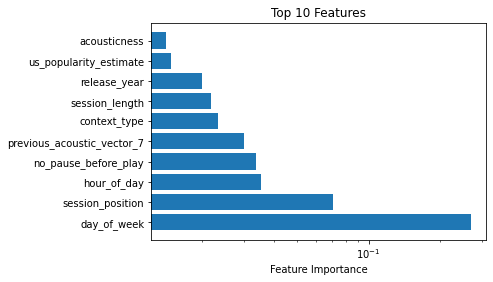

In [0]:
import matplotlib.pyplot as plt

top_n = 10
importances = DTmodel.featureImportances
feature_names = [col for col in test_spdf.columns if col != 'skipped']
sorted_importances = sorted(zip(importances, feature_names), key=lambda x: x[0], reverse=True)
top_n_importances = sorted_importances[:top_n]

x = [feature_name for _, feature_name in top_n_importances]
y = [importance for importance, _ in top_n_importances]

plt.barh(x, y)
plt.xscale('log')
plt.xlabel('Feature Importance')
plt.title('Top {} Features'.format(top_n))
plt.show()


In [0]:
print(DTmodel.toDebugString)

In [0]:
!pip install pydotplus

In [0]:
import pydotplus
from sklearn import tree
from IPython.display import Image

dot_data = tree.export_graphviz(DTmodel, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 

Image(graph.create_png())
